In [87]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

import warnings
warnings.filterwarnings('ignore')

In [88]:
df = pd.read_csv(r'D:\Code\bread_dano_2024\Code\data\data_final_preprocessed.csv')

Оставляю только людей без подписки и с подпиской Pro

In [89]:
df = df[df['bundle_nm'].isin(['Без подписки', 'Pro'])]
df['pro_flg'] = df['bundle_nm'].map({'Без подписки': 0, 'Pro': 1})

Разделяю причины звонка на бакеты: Продажи, Обработка заявок, Поддержка

Делаю стат.тесты по группам: Фишера для маленьких групп, Хи - для остальных

In [90]:
results = []
for product, group in df.groupby('product'):
    contingency_table = pd.crosstab(group['bundle_nm'], group['approval_flg'])

    if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
        results.append({
            'product': product,
            'test': 'Нет данных',
            'p_value': None,
            'significant': None
        })
        continue

    if contingency_table.values.min() < 5:
        stat, p_value = stats.fisher_exact(contingency_table, alternative='two-sided')
        test_type = 'Fisher'
    else:
        stat, p_value, _, _ = stats.chi2_contingency(contingency_table)
        test_type = 'Chi2'

    results.append({
        'product': product,
        'test': test_type,
        'p_value': p_value,
        'significant': p_value < 0.05
    })

results_df = pd.DataFrame(results)
results_df

,product,test,p_value,significant
0,Credits,Chi2,0.176855,False
1,Debit and Investment,Chi2,0.007054,True
2,Insurance and Services,Chi2,0.404185,False


In [91]:
stats.mannwhitneyu((df[df['pro_flg'] == 1]['approval_flg']), (df[df['pro_flg'] == 0]['approval_flg']))

MannwhitneyuResult(statistic=np.float64(22230984.0), pvalue=np.float64(0.012692148629510696))

In [92]:
d = df.groupby(['product', 'pro_flg'])['approval_flg'].agg(mean='mean', count='count')
d[d['count'] > 30]

mean  count
product                pro_flg                 
Credits                0        0.070961   8864
                       1        0.063014   2555
Debit and Investment   0        0.257431   1884
                       1        0.193317    419
Insurance and Services 0        0.115160   1372
                       1        0.128514    747

In [93]:
df['product'].unique()

array(['Credits', 'Insurance and Services', 'Debit and Investment'],
      dtype=object)

In [94]:
df['age'] = scaler.fit_transform(df[['age']])
for col in df['product'].unique():
    df1 = df[df['product'] == col]
    X = df1[['pro_flg', 'age', 'gender_cd']]
    y = df1['approval_flg']
    X = sm.add_constant(X)
    probit_model = sm.Logit(y, X)
    probit_result = probit_model.fit()
    print(probit_result.summary())

Optimization terminated successfully.
         Current function value: 0.251097
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           approval_flg   No. Observations:                11419
Model:                          Logit   Df Residuals:                    11415
Method:                           MLE   Df Model:                            3
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                0.001682
Time:                        11:39:42   Log-Likelihood:                -2867.3
converged:                       True   LL-Null:                       -2872.1
Covariance Type:            nonrobust   LLR p-value:                   0.02170
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6779      0.058    -46.045      0.000      -2.792      -2.564
pro_flg       -0.1373      0.

In [95]:
df['age'] = scaler.fit_transform(df[['age']])
df['emp_age_new'] = scaler.fit_transform(df[['emp_age_new']])
df1 = df[df['product'] == 'Debit and Investment']
df1.dropna(subset=['emp_age_new', 'child_flg', 'holiday_flg', 'million_city'], inplace=True)
X = df1[['pro_flg', 'age']]
y = df1['approval_flg']
X = sm.add_constant(X)
probit_model = sm.Logit(y, X)
probit_result = probit_model.fit()
print(probit_result.summary())

Optimization terminated successfully.
         Current function value: 0.571433
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           approval_flg   No. Observations:                 1125
Model:                          Logit   Df Residuals:                     1122
Method:                           MLE   Df Model:                            2
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                 0.02934
Time:                        11:39:42   Log-Likelihood:                -642.86
converged:                       True   LL-Null:                       -662.29
Covariance Type:            nonrobust   LLR p-value:                 3.633e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8134      0.078    -10.396      0.000      -0.967      -0.660
pro_flg       -0.8540      0.

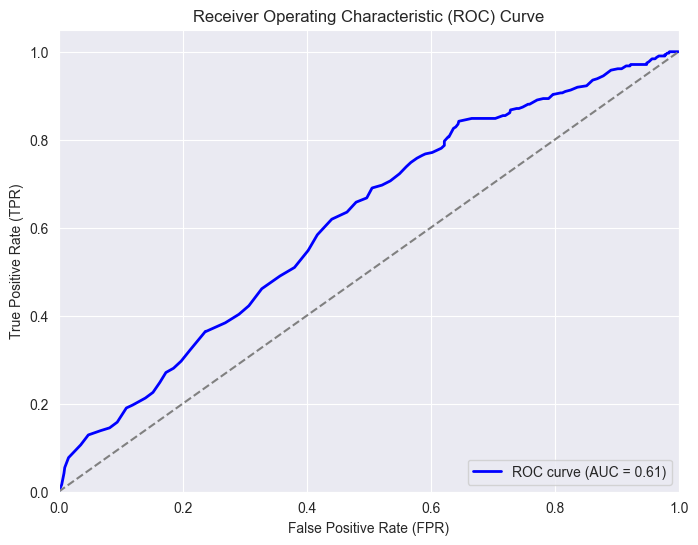

In [96]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities from the probit model
y_pred_prob = probit_result.predict(X)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
